# ST>A | Special Topics in Astrodynamics | ae4889

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer
from IPython.core.display import Image, display

print(f"tensorflow version: {tf.__version__}")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = plt.rcParams['axes.spines.right'] = False
np.set_printoptions(precision=4, suppress=True)

JULIAN_DAY = 86400.0
launch_window22 = 8304.5 * JULIAN_DAY

departure_range = np.array([-25, 24]) * JULIAN_DAY + launch_window22
arrival_range = np.array([-25 + 60, 24 + 449]) * JULIAN_DAY + launch_window22
time_of_flight_range = arrival_range - departure_range

raw_data = np.loadtxt('Output.txt', skiprows=1, delimiter=',')[:10000]
time_of_flight = raw_data[:, 1] - raw_data[:, 0]

raw_data = np.vstack((raw_data[:, 0], time_of_flight, raw_data[:, 1], raw_data[:, 2], raw_data[:, 3])).T

tensorflow version: 2.0.0


In [2]:
raw_data.shape

(10000, 5)

In [3]:
column_names = ['Departure time [s]', 'Time of flight [s]', 'Arrival time [s]', '∆V_1 [m/s]', '∆V_2 [m/s]']
raw_dataset = pd.DataFrame(data=raw_data, columns=column_names)

In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset.groupby(['Departure time [s]', 'Time of flight [s]'], as_index=False).count()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
0,715349311.0,37941742.0,1,1,1
1,715349397.0,35077117.0,1,1,1
2,715349517.0,9365127.0,1,1,1
3,715350019.0,36360296.0,1,1,1
4,715350051.0,7687397.0,1,1,1
...,...,...,...,...,...
9995,719666812.0,23642639.0,1,1,1
9996,719667866.0,33235747.0,1,1,1
9997,719668180.0,8473451.0,1,1,1
9998,719668228.0,23895785.0,1,1,1


### Raw Data

In [6]:
dataset

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
0,715551566.0,17470756.0,733022322.0,3577.063946,4726.501883
1,719297160.0,26748392.0,746045552.0,4106.990821,5541.734301
2,716105905.0,9450037.0,725555942.0,126.185950,368.164990
3,715783574.0,24993606.0,740777180.0,3937.910408,5411.901896
4,717645486.0,13975971.0,731621457.0,3392.797231,4352.089213
...,...,...,...,...,...
9995,718931005.0,18296486.0,737227491.0,4187.010686,5728.792562
9996,715414850.0,33710261.0,749125111.0,3822.305747,5129.550077
9997,715884224.0,12890022.0,728774246.0,2473.809625,2967.352386
9998,718869220.0,19449040.0,738318260.0,4192.062617,5752.821704


In [7]:
#sns.pairplot(dataset, diag_kind="kde")

### Split Data Up

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Training Data

In [9]:
train_dataset

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
9394,719229983.0,15699024.0,734929007.0,4150.660986,5605.357177
898,718090346.0,22155989.0,740246335.0,4090.411588,5608.584853
2398,715763231.0,38581635.0,754344866.0,3677.764211,4817.847624
5906,716828947.0,37643043.0,754471990.0,3692.467633,4808.633023
2343,718772279.0,9352248.0,728124527.0,1924.030432,2064.821560
...,...,...,...,...,...
8673,716119145.0,5914333.0,722033478.0,7054.137890,9316.331660
8175,718742467.0,20543599.0,739286066.0,4172.431364,5734.599941
4933,718360723.0,34189100.0,752549823.0,3790.267427,4976.336695
504,719537893.0,10531381.0,730069274.0,3212.192983,3962.567210


In [10]:
train_dataset.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8000.000000
mean,7.174807e+08,2.203033e+07,7.395110e+08,3539.523852,4717.928143
std,1.261710e+06,9.783882e+06,9.865719e+06,1093.900224,1513.068036
min,7.153493e+08,5.187969e+06,7.207912e+08,2.592238,4.384162
25%,7.163661e+08,1.344767e+07,7.308687e+08,3533.797340,4637.829510
50%,7.174886e+08,2.211803e+07,7.396387e+08,3835.191457,5121.910035
75%,7.185841e+08,3.054133e+07,7.480440e+08,3976.538471,5413.792118
max,7.196683e+08,3.886766e+07,7.584644e+08,10688.860251,13496.468860


In [11]:
#sns.pairplot(train_dataset, diag_kind="kde")

## Normalisation

In [12]:
def normalise_dataset(dataset):
    for i, the_range in zip(column_names, [departure_range, time_of_flight_range, arrival_range]):
        dataset[i] = (dataset[i] - the_range.min()) / (the_range.max() - the_range.min())

    for column in column_names[3:]:
        column_stats = dataset[column].describe()
        dataset[column] = (dataset[column] - column_stats.loc['mean']) / column_stats.loc['std']

    return dataset

train_data_normalised = normalise_dataset(train_dataset.copy())

In [13]:
train_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
9394,0.916757,0.312858,0.380417,0.558677,0.586510
898,0.647568,0.504974,0.520927,0.503600,0.588643
2398,0.097891,0.993693,0.893478,0.126374,0.066038
5906,0.349619,0.965767,0.896837,0.139815,0.059948
2343,0.808645,0.124020,0.200610,-1.476820,-1.753462
...,...,...,...,...,...
8673,0.181960,0.021730,0.039655,3.212920,3.039125
8175,0.801603,0.457000,0.495552,0.578579,0.671927
4933,0.711433,0.863000,0.846044,0.229220,0.170784
504,0.989487,0.159103,0.252000,-0.299233,-0.499225


In [14]:
train_data_normalised.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,8000.000000,8000.000000,8000.000000,8.000000e+03,8.000000e+03
mean,0.503570,0.501236,0.501497,2.362555e-16,2.415845e-16
std,0.298023,0.291104,0.260700,1.000000e+00,1.000000e+00
min,0.000121,0.000118,0.006827,-3.233322e+00,-3.115223e+00
25%,0.240287,0.245872,0.273123,-5.234949e-03,-5.293789e-02
50%,0.505431,0.503845,0.504870,2.702875e-01,2.669952e-01
75%,0.764188,0.754467,0.726978,3.995014e-01,4.599026e-01
max,1.020279,1.002203,1.002335,6.535638e+00,5.801815e+00


In [15]:
#sns.pairplot(train_data_normalised, diag_kind="kde")

### Training data

In [16]:
train_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
9394,0.916757,0.312858,0.380417,0.558677,0.586510
898,0.647568,0.504974,0.520927,0.503600,0.588643
2398,0.097891,0.993693,0.893478,0.126374,0.066038
5906,0.349619,0.965767,0.896837,0.139815,0.059948
2343,0.808645,0.124020,0.200610,-1.476820,-1.753462
...,...,...,...,...,...
8673,0.181960,0.021730,0.039655,3.212920,3.039125
8175,0.801603,0.457000,0.495552,0.578579,0.671927
4933,0.711433,0.863000,0.846044,0.229220,0.170784
504,0.989487,0.159103,0.252000,-0.299233,-0.499225


In [17]:
train_data_normalised.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Departure time [s],8000.0,5.035700e-01,0.298023,0.000121,0.240287,0.505431,0.764188,1.020279
Time of flight [s],8000.0,5.012357e-01,0.291104,0.000118,0.245872,0.503845,0.754467,1.002203
Arrival time [s],8000.0,5.014968e-01,0.260700,0.006827,0.273123,0.504870,0.726978,1.002335
∆V_1 [m/s],8000.0,2.362555e-16,1.000000,-3.233322,-0.005235,0.270288,0.399501,6.535638
∆V_2 [m/s],8000.0,2.415845e-16,1.000000,-3.115223,-0.052938,0.266995,0.459903,5.801815


## Model


In [18]:
model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape=[2]),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 5,352
Trainable params: 5,352
Non-trainable params: 0
_________________________________________________________________


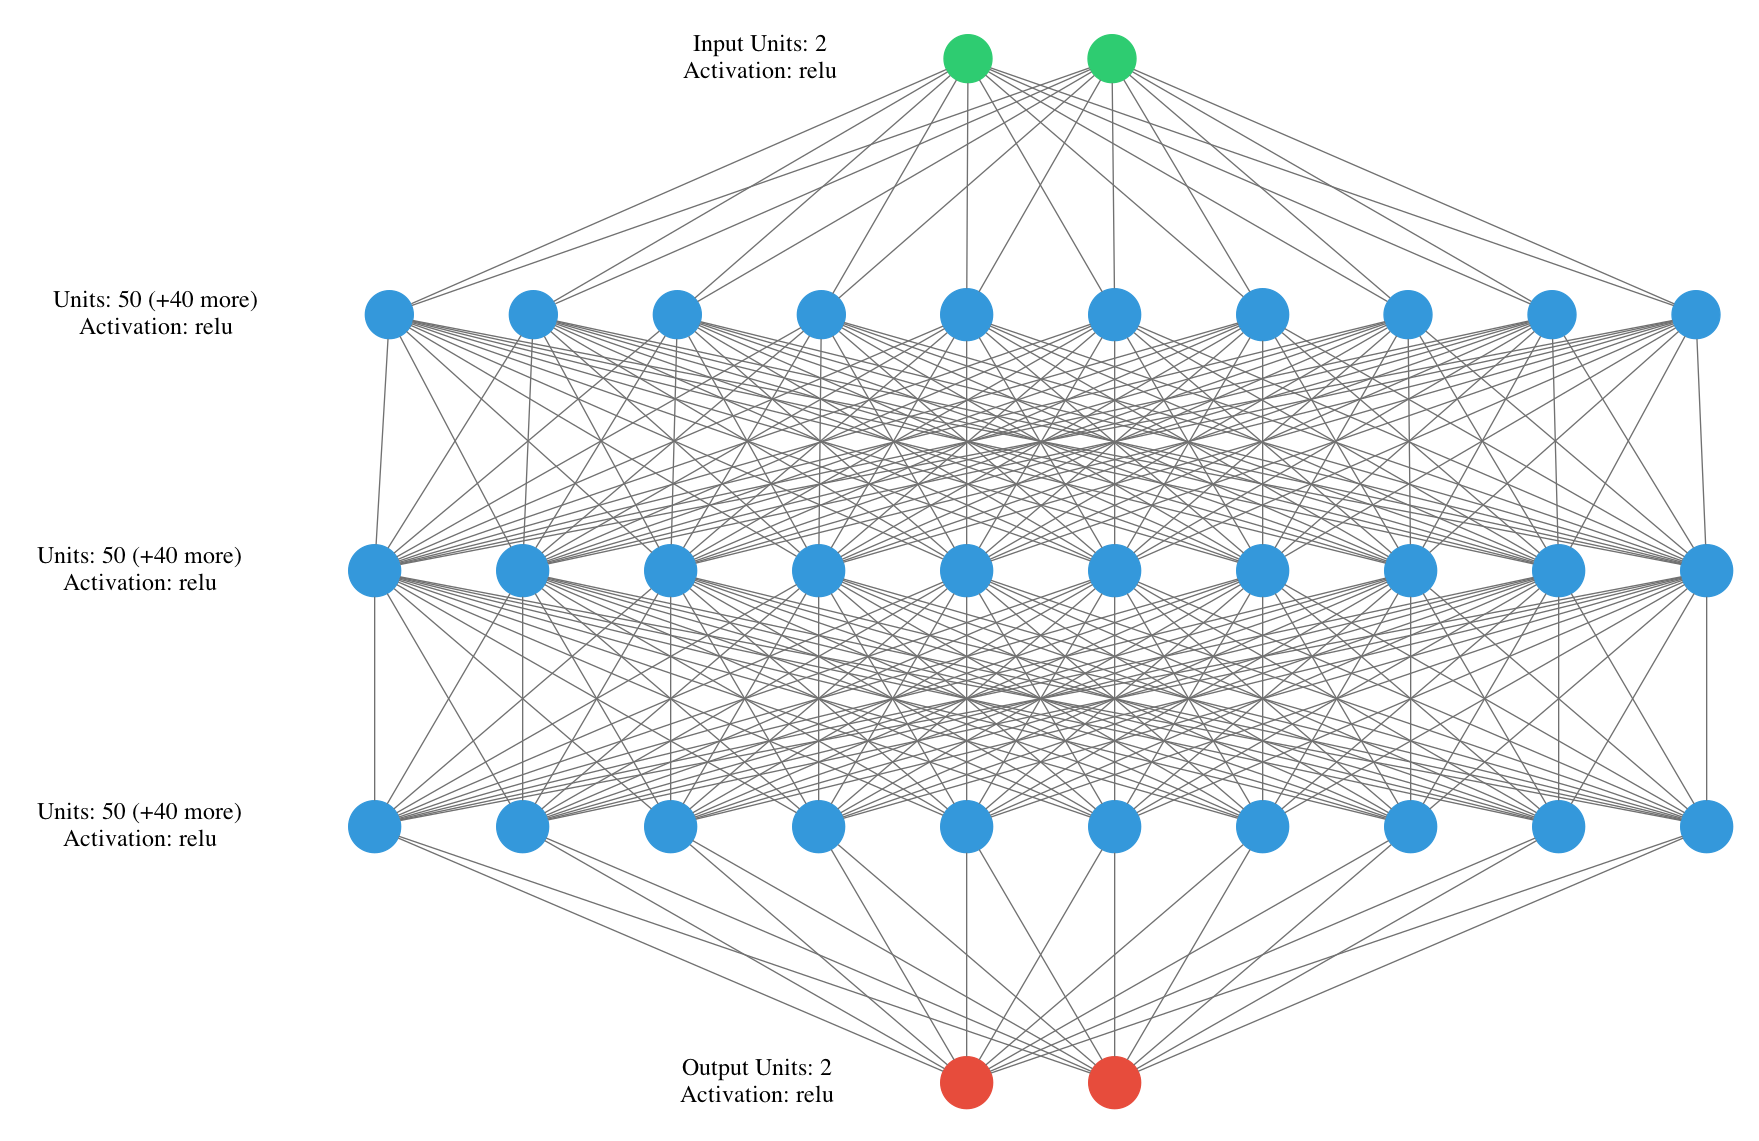

In [20]:
visualizer(model, format='png')
display((Image(filename='graph.png')))

In [21]:
%%time
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0005,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(train_data_normalised[[column_names[0], column_names[1]]].to_numpy(),
                    train_data_normalised[[column_names[3], column_names[4]]].to_numpy(),
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=500,
                    callbacks=[early_stop])

Train on 6400 samples, validate on 1600 samples
Epoch 1/1000
6400/6400 [==============================] - 1s 114us/sample - loss: 0.9952 - accuracy: 0.5422 - val_loss: 0.9681 - val_accuracy: 0.6538
Epoch 2/1000
6400/6400 [==============================] - 0s 12us/sample - loss: 0.9535 - accuracy: 0.6323 - val_loss: 0.9281 - val_accuracy: 0.5688
Epoch 3/1000
6400/6400 [==============================] - 0s 12us/sample - loss: 0.9038 - accuracy: 0.5086 - val_loss: 0.8770 - val_accuracy: 0.5831
Epoch 4/1000
6400/6400 [==============================] - 0s 13us/sample - loss: 0.8474 - accuracy: 0.5592 - val_loss: 0.8255 - val_accuracy: 0.5219
Epoch 5/1000
6400/6400 [==============================] - 0s 13us/sample - loss: 0.7908 - accuracy: 0.5530 - val_loss: 0.7811 - val_accuracy: 0.6844
Epoch 6/1000
6400/6400 [==============================] - 0s 12us/sample - loss: 0.7459 - accuracy: 0.5763 - val_loss: 0.7449 - val_accuracy: 0.6494
Epoch 7/1000
6400/6400 [==============================] -

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
81,0.000868,0.959844,0.000895,0.948125,81
82,0.000816,0.958906,0.001002,0.957500,82
83,0.000862,0.959531,0.000907,0.951250,83
84,0.000757,0.957969,0.000822,0.951250,84
85,0.000762,0.958594,0.000962,0.948750,85


In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

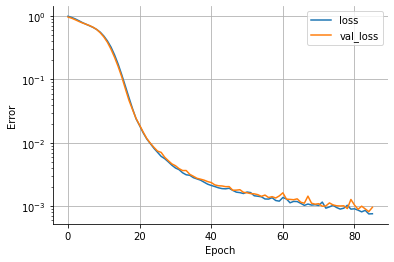

In [24]:
plot_loss(history)

In [25]:
test_dataset.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2000.000000
mean,7.175045e+08,2.241212e+07,7.399166e+08,3597.347308,4804.051089
std,1.235283e+06,9.624086e+06,9.722115e+06,1056.194509,1441.172915
min,7.153495e+08,5.201334e+06,7.207486e+08,0.468314,13.558098
25%,7.164335e+08,1.436541e+07,7.317973e+08,3648.917879,4713.203201
50%,7.175221e+08,2.252822e+07,7.399564e+08,3850.944605,5152.693691
75%,7.185791e+08,3.084214e+07,7.483417e+08,3988.372370,5430.056629
max,7.196639e+08,3.887948e+07,7.582411e+08,10808.241639,13623.541329


In [26]:
test_data_normalised = normalise_dataset(test_dataset.copy())

In [27]:
test_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
0,0.047894,0.365573,0.330033,-0.019204,-0.053810
13,0.447699,0.413988,0.417760,0.323246,0.362766
21,1.004164,0.330939,0.406254,0.678701,0.732649
25,0.480736,0.008989,0.061765,2.881561,2.881437
26,0.196869,0.210249,0.208752,-1.255824,-1.486919
...,...,...,...,...,...
9963,0.534452,0.131806,0.176851,-2.188514,-2.531228
9969,1.003502,0.644101,0.684308,0.513372,0.523934
9972,0.485156,0.344288,0.360047,0.180404,0.162662
9982,0.786142,0.269798,0.327563,0.173693,0.136345


In [28]:
prediction = model.predict(test_data_normalised[[column_names[0], column_names[1]]].to_numpy())

In [29]:
pd.DataFrame(data=prediction, columns=[column_names[3], column_names[4]])

,∆V_1 [m/s],∆V_2 [m/s]
0,0.004024,0.029452
1,0.375262,0.430084
2,0.699519,0.747406
3,2.884682,2.793416
4,-1.114349,-1.337813
...,...,...
1995,-2.082303,-2.346913
1996,0.548291,0.581596
1997,0.238110,0.252508
1998,0.249480,0.207911


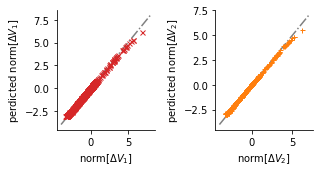

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.55, 2.5))
ax1.plot(np.linspace(-4, 8), np.linspace(-4, 8), '-.', c='0.5')
ax2.plot(np.linspace(-4, 7), np.linspace(-4, 7), '-.', c='0.5')
ax1.plot(test_data_normalised[column_names[3]], prediction[:, 0], 'x', label=fr'$\Delta V_1$', fillstyle='none', markersize=5, c='C3', rasterized=True)
ax2.plot(test_data_normalised[column_names[4]], prediction[:, 1], '+', label=fr'$\Delta V_2$', fillstyle='none', markersize=5, c='C1', rasterized=True)


for i, ax in enumerate([ax1, ax2]):
    ax.set_ylabel(fr'perdicted norm[$\Delta V_{i+1}$]')
    ax.set_xlabel(fr'norm[$\Delta V_{i+1}$]')
#    ax.legend(frameon=False)

fig.tight_layout()
# fig.savefig('case_3_pred_vs_test.pdf', dpi=450)

In [31]:
errors = pd.DataFrame(data=np.vstack((test_data_normalised[column_names[3]] - prediction[:, 0], test_data_normalised[column_names[4]] - prediction[:, 1])).T,
                      columns=["norm[∆V_1] error", "norm[∆V_2] error"])
errors.describe()

,norm[∆V_1] error,norm[∆V_2] error
count,2000.000000,2000.000000
mean,-0.063343,-0.066813
std,0.043788,0.051592
min,-0.318688,-0.448099
25%,-0.069061,-0.081998
50%,-0.058540,-0.057708
75%,-0.050137,-0.046488
max,0.675156,0.579054


In [32]:
errors

,norm[∆V_1] error,norm[∆V_2] error
0,-0.023229,-0.083261
1,-0.052016,-0.067317
2,-0.020818,-0.014757
3,-0.003122,0.088021
4,-0.141475,-0.149106
...,...,...
1995,-0.106210,-0.184316
1996,-0.034919,-0.057662
1997,-0.057706,-0.089846
1998,-0.075787,-0.071566


In [33]:
errors.shape

(2000, 2)

-0.06334327020740615 0.04377714286398406 -0.019566127343422092 -0.06681347963959008 0.05157886040341627 -0.015234619236173814 

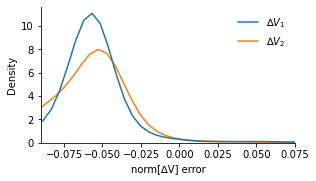

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4.55, 2.5))

def plot_normal(data, **kwargs):
    mean, std = np.average(data), np.std(data)
    x = np.linspace(-0.2, 0.2, 1000)
    # ax.plot(x, norm.pdf(x, mean, std), **kwargs)
    print(mean, std, mean + std, end=' ', sep=' ')

# ax.hist(errors["norm[∆V_1] error"], bins=101, label=rf"$\Delta$V$_1$", density=True, alpha=0.85)
# ax.hist(errors["norm[∆V_2] error"], bins=101, label=rf"$\Delta$V$_2$", density=True, alpha=0.85)
# plot_normal(test_data_normalised[column_names[3]] - prediction[:, 0], c='C0')
# plot_normal(test_data_normalised[column_names[4]] - prediction[:, 1], c='C1')

# ax.legend(frameon=False)
# ax.set_xlim((-0.035,0.075))
# ax.set_ylabel('normalised frequency [-]')
# ax.set_xlabel(r'normalised $\Delta V$ error [-]')

plot_normal(errors["norm[∆V_1] error"])
plot_normal(errors["norm[∆V_2] error"])
errors_sns = pd.DataFrame(data=errors.to_numpy().T.flatten(), columns=['norm[∆V] error'])
n_points = errors_sns.shape[0] // 2
errors_sns['∆V'] = ['$∆V_1$'] * n_points + ['$∆V_2$'] * n_points 
g = sns.kdeplot(ax=ax, data=errors_sns, x="norm[∆V] error", hue="∆V")
g.set(xlim=(-0.09, 0.075))
g.get_legend().set_title(None)
g.get_legend().draw_frame(False)
#fig.savefig('case_3_error_histogram.pdf')